# Introduction
Hey, thanks for viewing my Kernel!

If you like my work, please, leave an upvote: it will be really appreciated and it will motivate me in offering more content to the Kaggle community ! :)

EDA was done in this [notebook](https://www.kaggle.com/code/hasanbasriakcay/tpsapr22-eda-fe-baseline)</br>
Pseudo Labeling was done in this [notebook](https://www.kaggle.com/code/hasanbasriakcay/tpsapr22-fe-pseudo-labels-baseline)</br>
Prediction without NN is in this [notebook](https://www.kaggle.com/code/hasanbasriakcay/tpsapr22-optuna-lgbm-blend)

In [1]:
import pandas as pd
import numpy as np
import warnings 

warnings.simplefilter("ignore")
train = pd.read_csv("../input/tabular-playground-series-apr-2022/train.csv")
test = pd.read_csv("../input/tabular-playground-series-apr-2022/test.csv")
test_pseudo = pd.read_csv("../input/tpsapr22-pseudo-labels/pseudo_labeled_test.csv")
train_labels = pd.read_csv("../input/tabular-playground-series-apr-2022/train_labels.csv")
sub = pd.read_csv("../input/tabular-playground-series-apr-2022/sample_submission.csv")

display(train.head())
display(test.head())
display(train_labels.head())
display(sub.head())

,sequence,subject,step,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12
0,0,47,0,-0.196291,0.112395,1.0,0.329204,-1.004660,-0.131638,-0.127505,0.368702,-0.1,-0.963873,-0.985069,0.531893,4.751492
1,0,47,1,-0.447450,0.134454,1.0,-0.658407,0.162495,0.340314,-0.209472,-0.867176,0.2,-0.301301,0.082733,-0.231481,0.454390
2,0,47,2,0.326893,-0.694328,1.0,0.330088,0.473678,1.280479,-0.094718,0.535878,1.4,1.002168,0.449221,-0.586420,-4.736147
3,0,47,3,0.523184,0.751050,1.0,0.976991,-0.563287,-0.720269,0.793260,0.951145,-0.3,-0.995665,-0.434290,1.344650,0.429241
4,0,47,4,0.272025,1.074580,1.0,-0.136283,0.398579,0.044877,0.560109,-0.541985,-0.9,1.055636,0.812631,0.123457,-0.223359


,sequence,subject,step,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12
0,25968,684,0,2.427357,19.639706,1.0,-1.466372,-1.289973,-4.207928,2.486339,-2.493893,8.0,-1.123555,-1.673048,10.980453,0.419011
1,25968,684,1,-4.950541,-21.747899,1.0,0.983186,-0.569053,1.845924,-3.887978,1.727481,-2.9,0.395231,-0.882233,-1.871399,-0.008525
2,25968,684,2,1.136012,-10.756303,1.0,1.016814,0.964157,2.454749,0.312386,1.154198,-5.6,1.114162,1.525273,-11.584362,0.139812
3,25968,684,3,0.806028,6.504202,1.0,-0.179646,0.969221,-1.035153,-0.457195,0.254962,-2.7,-0.588873,0.608761,-4.241770,-0.462916
4,25968,684,4,1.288253,5.552521,1.0,-0.493805,-1.036124,-1.126402,2.008197,-0.730534,0.0,0.899566,-1.259615,-0.472222,-0.121483


,sequence,state
0,0,0
1,1,1
2,2,1
3,3,1
4,4,1


,sequence,state
0,25968,0
1,25969,0
2,25970,0
3,25971,0
4,25972,0


In [2]:
th = 0.95
test_pseudo_selected = test_pseudo.loc[((test_pseudo['state_proba']>=th) | (test_pseudo['state_proba']<=(1 - th))), 
                                      ['sequence', 'state_proba']]
test_pseudo_selected.columns = ['sequence', 'state']
test_pseudo_selected['state'] = test_pseudo_selected['state'].round()
test_pseudo_selected.head()

,sequence,state
7,25975,0.0
8,25976,1.0
9,25977,0.0
10,25978,0.0
19,25987,0.0


# Feature Engineering

In [3]:
def create_new_features(df):
    df['sensor_02_num'] = df['sensor_02'] > -15
    df['sensor_02_num'] = df['sensor_02_num'].astype(int)
    df['sensor_sum1'] = (df['sensor_00'] + df['sensor_09'] + df['sensor_06'] + df['sensor_01'])
    df['sensor_sum2'] = (df['sensor_01'] + df['sensor_11'] + df['sensor_09'] + df['sensor_06'] + df['sensor_00'])
    df['sensor_sum3'] = (df['sensor_03'] + df['sensor_11'] + df['sensor_07'])
    df['sensor_sum4'] = (df['sensor_04'] + df['sensor_10'])
    
    sensors = ['sensor_'+'%02d'%i for i in range(0, 13)]
    sensors.extend(['sensor_02_num', 'sensor_sum1', 'sensor_sum2', 'sensor_sum3', 'sensor_sum4'])
    
    for sensor in sensors:
        df[sensor + '_lag1'] = df.groupby('sequence')[sensor].shift(1)
        df.fillna(0, inplace=True)
        df[sensor + '_diff1'] = df[sensor] - df[sensor + '_lag1'] 
    
    return df

In [4]:
train = create_new_features(train)
test = create_new_features(test)

In [5]:
selected_test = test.loc[test['sequence'].isin(test_pseudo_selected['sequence']), :].copy()
selected_test = selected_test.merge(test_pseudo_selected[['sequence', 'state']], on='sequence', how='left')
selected_test.reset_index(inplace=True, drop=True)

In [6]:
train = pd.merge(train, train_labels, how='left', on="sequence")
train = pd.concat([train, selected_test])
groups = train['sequence']

In [7]:
Window = 60
y = train['state'].to_numpy().reshape(-1, Window)
train.drop(["sequence","step","subject","state"], axis=1, inplace=True)
test.drop(["sequence","step","subject"], axis=1, inplace=True)

In [8]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(train)
X_train = sc.transform(train)
X_test = sc.transform(test)

In [9]:
X_train = X_train.reshape(-1, Window, X_train.shape[-1])
X_test = X_test.reshape(-1, Window, X_test.shape[-1])

In [10]:
print(y.shape, X_train.shape, X_test.shape)

(28500, 60) (28500, 60, 54) (12218, 60, 54)


In [11]:
y_train = y.copy()

In [12]:
#y_train = y[:, 0:2]
#y_train[:, 0] = np.logical_not(y_train[:, 0]).astype(int)
#y_train

# Modeling

In [13]:
from tensorflow.keras import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.metrics import AUC

def get_model():
    input_layer = Input(shape=(X_train.shape[-2:]))
    x1 = Bidirectional(LSTM(768, return_sequences=True))(input_layer)
        
    x21 = Bidirectional(LSTM(512, return_sequences=True))(x1)
    x22 = Bidirectional(LSTM(512, return_sequences=True))(input_layer)
    l2 = Concatenate(axis=2)([x21, x22])
        
    x31 = Bidirectional(LSTM(384, return_sequences=True))(l2)
    x32 = Bidirectional(LSTM(384, return_sequences=True))(x21)
    l3 = Concatenate(axis=2)([x31, x32])
        
    x41 = Bidirectional(LSTM(256, return_sequences=True))(l3)
    x42 = Bidirectional(LSTM(128, return_sequences=True))(x32)
    l4 = Concatenate(axis=2)([x41, x42])
        
    l5 = Concatenate(axis=2)([x1, l2, l3, l4])
    x7 = Dense(128, activation='selu')(l5)
    x8 = Dropout(0.3)(x7)
    output_layer = Dense(units=1, activation="sigmoid")(x8)
    model = Model(inputs=input_layer, outputs=output_layer, name='DNN_Model')
    model.compile(optimizer="adam",loss="binary_crossentropy", metrics=[AUC(name = 'auc')])
    
    return model

In [14]:
model = get_model()
model.summary()

2022-04-08 15:44:38.645312: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-08 15:44:38.749087: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-08 15:44:38.750248: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-08 15:44:38.752536: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "DNN_Model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60, 54)]     0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 60, 1536)     5056512     input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 60, 1024)     8392704     bidirectional[0][0]              
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 60, 1024)     2322432     input_1[0][0]                    
__________________________________________________________________________________________

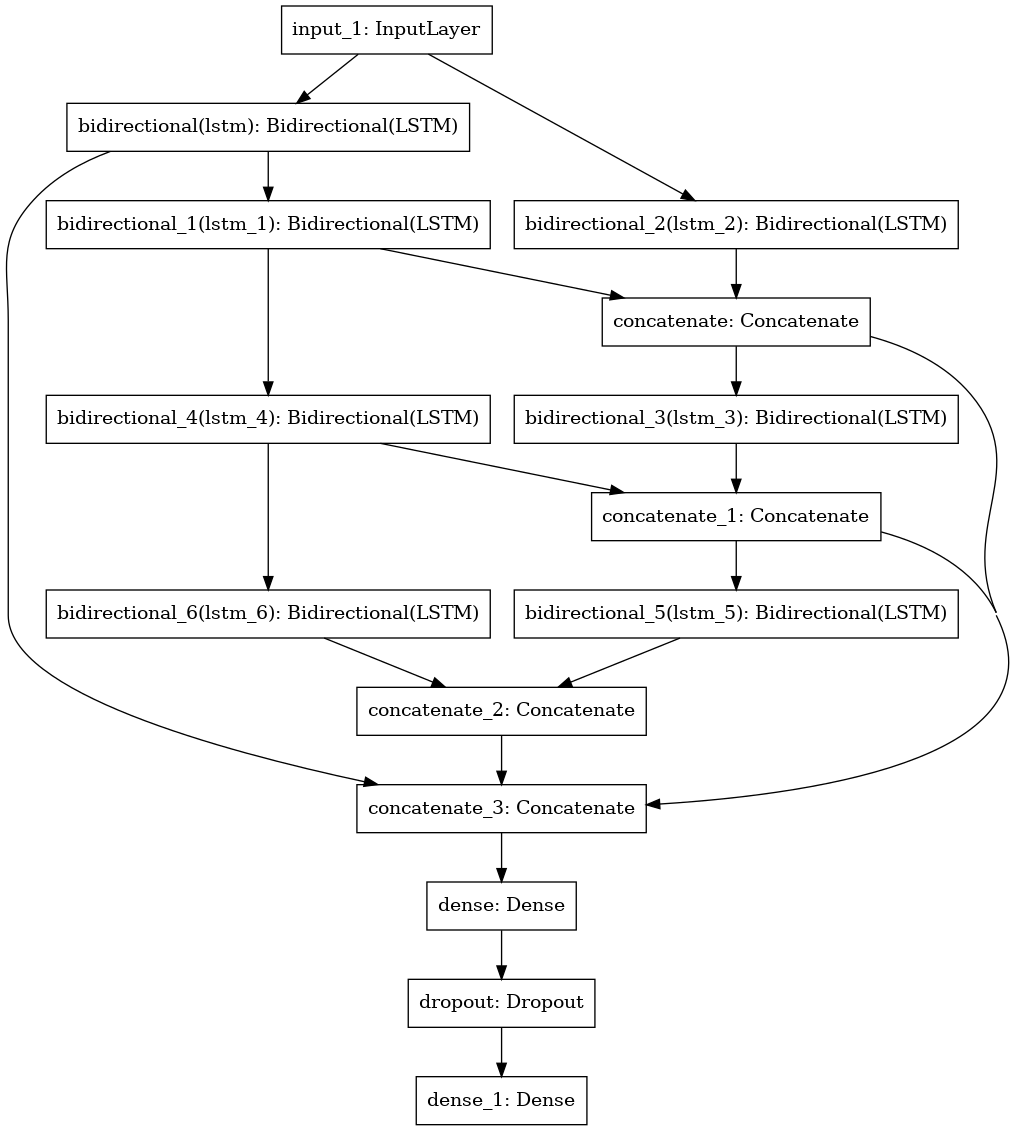

In [15]:
utils.plot_model(model)

# Predictions

In [16]:
import matplotlib.pyplot as plt

def plot_hist(hist, metric='auc', ax=None, fold=0):
    if ax==None:
        plt.plot(hist.history[metric])
        plt.plot(hist.history["val_" + metric])
        plt.title(f"model performance fold {fold}")
        plt.ylabel("area_under_curve")
        plt.xlabel("epoch")
        plt.legend(["train", "validation"], loc="upper left")
        plt.show()
        return
    else:
        ax.plot(hist.history[metric])
        ax.plot(hist.history["val_" + metric])
        ax.set_title(f"model performance fold {fold}")
        ax.set_ylabel("area_under_curve")
        ax.set_xlabel("epoch")
        ax.legend(["train", "validation"], loc="upper left")

Fold: 1 

2022-04-08 15:44:55.664888: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-04-08 15:45:17.122084: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


auc: 0.97601
Fold: 2 auc: 0.96804
Fold: 3 auc: 0.97327
Fold: 4 auc: 0.97447
Fold: 5 auc: 0.97252
Fold: 6 auc: 0.96834
Fold: 7 auc: 0.97134
Fold: 8 auc: 0.97681
Fold: 9 auc: 0.96947
Fold: 10 auc: 0.97315


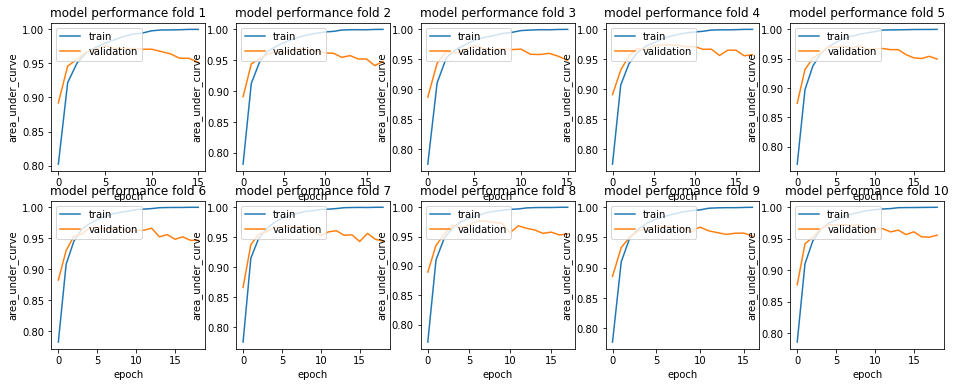

In [17]:
from sklearn.model_selection import KFold, GroupKFold
from sklearn.metrics import roc_auc_score
import gc

test_preds = []
auc = []
nfold = 10
ncols = 5
nrows = round(nfold / ncols)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, round(nrows*16/ncols)))

col, row = 0, 0
kf = GroupKFold(n_splits=nfold)
for fold, (train_idx, test_idx) in enumerate(kf.split(X_train, y_train, groups.unique())):
    print(f"Fold: {fold+1}", end=' ')
    X_train_part, X_valid = X_train[train_idx], X_train[test_idx]
    y_train_part, y_valid = y_train[train_idx], y_train[test_idx]
    
    model = get_model()
    lr = ReduceLROnPlateau(monitor="val_auc", mode='max', factor=0.7, patience=4, verbose=False)
    es = EarlyStopping(monitor='val_auc',mode='max', patience=10, verbose=False,restore_best_weights=True)
    history = model.fit(X_train_part, y_train_part, validation_data=(X_valid, y_valid), epochs=30, batch_size=64, 
                        callbacks=[es,lr], verbose=False)
    
    y_pred = model.predict(X_valid).squeeze()
    auc_score = roc_auc_score(y_valid, y_pred)
    print(f'auc: {round(auc_score, 5)}')
    test_preds.append(model.predict(X_test).squeeze())
    auc.append(auc_score)
    
    plot_hist(history, metric='auc', ax=axes[row][col], fold=fold+1)
    del X_train_part, X_valid, y_train_part, y_valid, model, history
    gc.collect()
    
    col += 1
    if col >= ncols:
        row += 1
        col = 0

In [18]:
print(f"the mean AUC for the {kf.n_splits} folds is : {round(np.mean(auc)*100,3)}")

the mean AUC for the 10 folds is : 97.234


In [19]:
sub_data = pd.read_csv("../input/tps-apr-2022-ensemble-solution/submission.csv")

In [20]:
sub['state'] = sum(test_preds)/kf.n_splits 
sub['state'] = (sub['state'] * 0.35) + (sub_data['state'] * 0.65)
sub.to_csv('submission.csv', index=False)
sub  

,sequence,state
0,25968,0.981974
1,25969,0.988178
2,25970,0.007887
3,25971,0.802117
4,25972,0.377276
...,...,...
12213,38181,0.339028
12214,38182,0.617083
12215,38183,0.246915
12216,38184,0.076056


# Referances:
1. [notebook](https://www.kaggle.com/code/hamzaghanmi/tps-april-tensorflow-bi-lstm)
2. [notebook](https://www.kaggle.com/code/cbeaud/tps-apr-2022-ensemble-solution/notebook)